In [1]:
import numpy as np
import pandas as pd
import os

### Load Tesla data

In [2]:
df=pd.read_csv('tesla.csv')

### EDA

In [3]:
!pip install pandas_profiling

  Using cached MarkupSafe-2.1.1-cp39-cp39-win_amd64.whl (17 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.


In [4]:
!pip install markupsafe==2.0.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.



  Using cached MarkupSafe-2.0.1-cp39-cp39-win_amd64.whl (14 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1


In [5]:
import pandas_profiling
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


### Check for Stationarity - ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.8137329693176625
p-value: 0.8150547908640395
Critial Values:
   1%, -3.434223006770802
Critial Values:
   5%, -2.8632507142793737
Critial Values:
   10%, -2.5676807398860144


### Apply Log transformation and test again

In [8]:
from numpy import log

result = adfuller(log(df['Adj Close'].values), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.877994903571474
p-value: 0.795132618367597
Critial Values:
   1%, -3.434223006770802
Critial Values:
   5%, -2.8632507142793737
Critial Values:
   10%, -2.5676807398860144


### ACF and PACF Plot

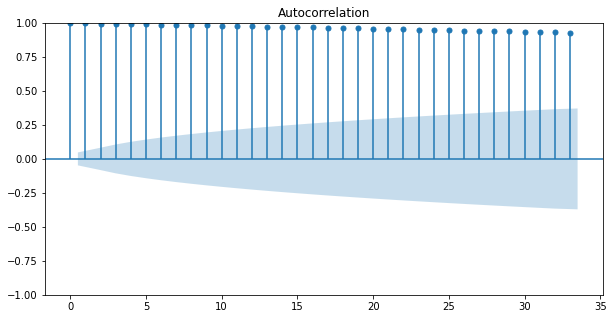

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10,5))
plot_acf(df['Adj Close'])
print()

C:\Users\18040\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


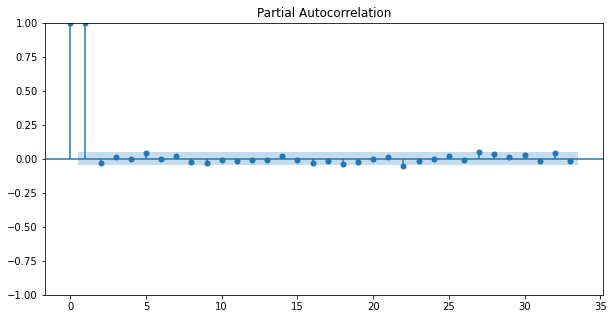

In [10]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Adj Close'])
print()

### Train - Test Split

In [11]:
data = df['Adj Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (1692,)


In [12]:
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  1353
Shape of Train and Test data:  1353 339


### Make time-series data supervised

In [13]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Choose Lag value

In [14]:
lag = 3 
n_features = 1

In [15]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [16]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (1350, 3) (1350,)
Shape of test_X and test_y:  (336, 3) (336,)


### Reshape train_X and test_X to 3-Dimension

In [17]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [18]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (1350, 3, 1) (1350,)
Shape of test_X and test_y:  (336, 3, 1) (336,)


### Building and Defining the model

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [20]:
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
# model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Fit the model - with training data

In [21]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [22]:
history = model.fit(train_X, train_y, epochs = 100, batch_size=64, verbose=1, validation_split= 0.1)

C:\Users\18040\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
19/19 [==============================] - 1s 19ms/step - loss: 19105.2305 - val_loss: 63986.6758
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 17334.4453 - val_loss: 61997.0000
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 16808.2383 - val_loss: 60475.2344
Epoch 4/100
19/19 [==============================] - 0s 19ms/step - loss: 16232.9629 - val_loss: 57972.3906
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 6063.6294 - val_loss: 232.6599
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 113.6611 - val_loss: 72.4023
Epoch 7/100
19/19 [==============================] - 0s 17ms/step - loss: 26.9108 - val_loss: 67.6499
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 24.3119 - val_loss: 62.2658
Epoch 9/100
19/19 [==============================] - 0s 17ms/step - loss: 23.3182 - val_loss: 57.0732
Epoch 10/100
19/19 [==============================] - 

19/19 [==============================] - 0s 19ms/step - loss: 15.8079 - val_loss: 41.1173
Epoch 81/100
19/19 [==============================] - 0s 17ms/step - loss: 16.0953 - val_loss: 41.5188
Epoch 82/100
19/19 [==============================] - 0s 19ms/step - loss: 17.2077 - val_loss: 42.5234
Epoch 83/100
19/19 [==============================] - 0s 17ms/step - loss: 17.1346 - val_loss: 54.0104
Epoch 84/100
19/19 [==============================] - 0s 19ms/step - loss: 16.5531 - val_loss: 41.4910
Epoch 85/100
19/19 [==============================] - 0s 20ms/step - loss: 17.3750 - val_loss: 40.7054
Epoch 86/100
19/19 [==============================] - 0s 18ms/step - loss: 17.2336 - val_loss: 56.5717
Epoch 87/100
19/19 [==============================] - 0s 18ms/step - loss: 16.8486 - val_loss: 40.7643
Epoch 88/100
19/19 [==============================] - 0s 18ms/step - loss: 16.3249 - val_loss: 43.5992
Epoch 89/100
19/19 [==============================] - 0s 17ms/step - loss: 15.7225 - v

### Summarize model accuracy and Loss

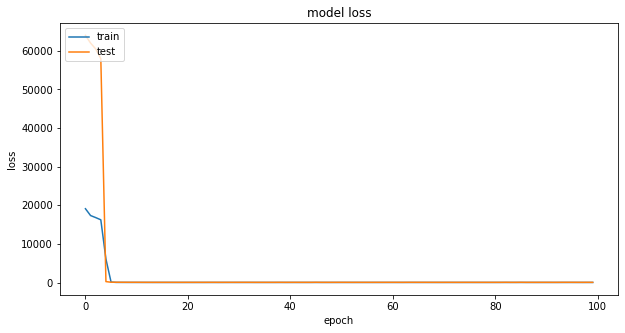

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Make prediction - with Test data

In [24]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

11/11 [==============================] - 0s 8ms/step
Shape of train and test predict:  (1350, 1) (336, 1)


###  Model evaluation

In [25]:
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  4.25109996449582 5.0163588427348405


### Plot test data and Predicted data

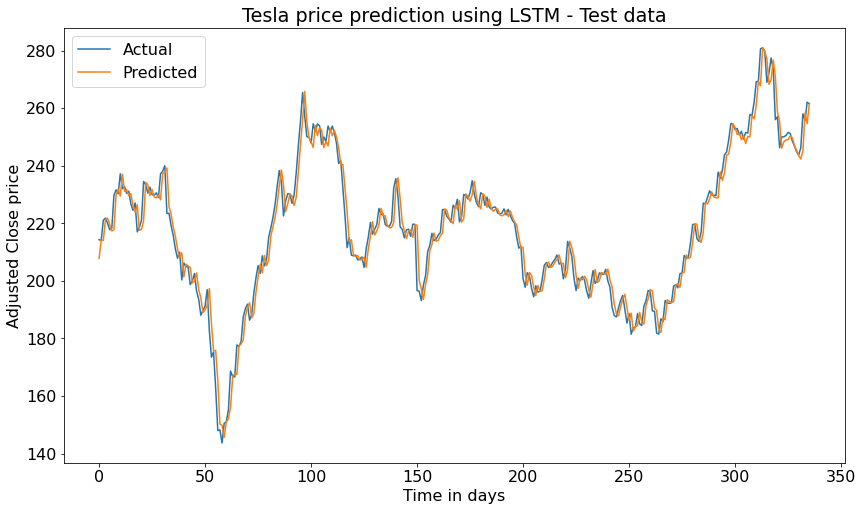

In [27]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Adjusted Close price')
plt.title('Tesla price prediction using LSTM - Test data')
plt.legend()
plt.show()